# Plane-based sampling
- Idea: subsample using the radius again, construct a plane based on the centroid and 2 closest points -> deviation from this plane approximates curvature

- Flaws:
    - depends on radius chosen

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = utils.import_train(100_000)

In [3]:
train_dataset

ModelNet10(3991)

In [4]:
point_cloud = train_dataset[1]  # 1000 = chair

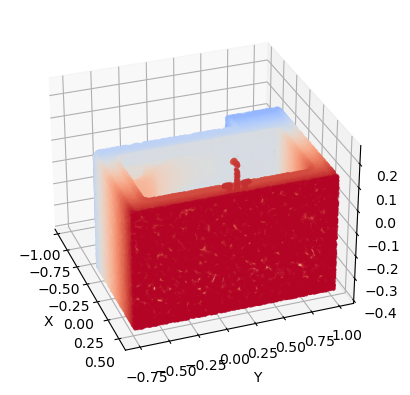

In [5]:
utils.draw_pointcloud(point_cloud)

Visualisation of neighbourhood function

In [6]:
point0 = point_cloud.pos[1]
nr_points = len(point_cloud.pos)
radius = .1
neighbours0 = utils.find_neighborhood(point_cloud.pos, point0, radius)

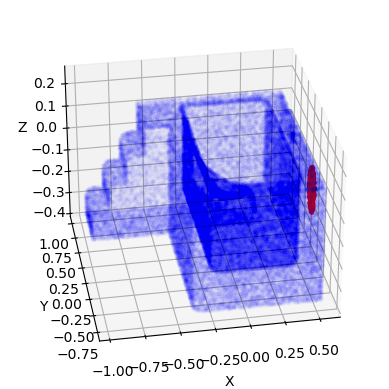

In [7]:
utils.draw_pointcloud_neighbour(point_cloud.pos, neighbours0, point0,radius,False)

# NOTE: should be weighted average distance to plane as closer points are more relevant to the curvature around that point

In [20]:
def calculate_average_distance(center_point, surrounding_points):
    # Calculate Euclidean distances from the center point to all surrounding points
    distances = np.linalg.norm(surrounding_points - center_point, axis=1)

    # Sort distances and select the indices of the 2 closest points
    closest_indices = np.argsort(distances)[:3]

    # Select the 2 closest points
    closest_points = surrounding_points[closest_indices]

    # Construct the plane using the three closest points
    v1 = closest_points[1] - closest_points[0]
    v2 = closest_points[2] - closest_points[0]
    normal_vector = np.cross(v1, v2)
    print(closest_points)
    print(normal_vector)
    d = -np.dot(normal_vector, closest_points[0])

    # Calculate the average distance from the plane for all surrounding points
    distances_from_plane = np.abs(np.dot(surrounding_points, normal_vector) + d) / np.linalg.norm(normal_vector)
    average_distance = np.mean(distances_from_plane)

    return average_distance


In [57]:
distances = np.linalg.norm(neighbours0 - point0, axis=1)

# Sort distances and select the indices of the three closest points
closest_indices = np.argsort(distances)[:5]

# Select the 2 closest points
closest_points = neighbours0[closest_indices]

In [69]:
res = np.cross(closest_points[1], closest_points[0])
x_range = np.linspace(closest_points[0][0] - radius, closest_points[0][1] + radius, 10)
y_range = np.linspace(closest_points[0][1] - radius, closest_points[0][1] + radius, 10)
x_plane, y_plane = np.meshgrid(x_range, y_range)

z_plane = (-res[0] * x_plane - res[1] * y_plane)

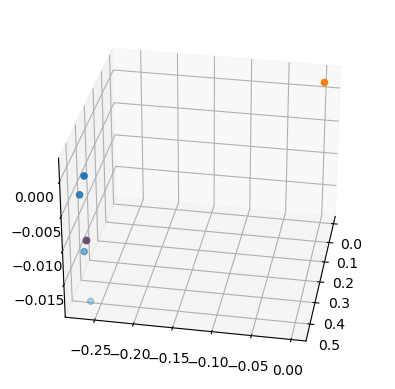

In [73]:
closest_points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point0[0],point0[1],point0[2], color='red')
ax.scatter(closest_points[:,0],closest_points[:,1],closest_points[:,2])
ax.view_init(elev=30, azim=10)
ax.scatter(res[0],res[1],res[2])

plt.show()

In [63]:
print(closest_points)
v1 = closest_points[2] - closest_points[0]
v2 = closest_points[1] - closest_points[0]

print(normal_vector)

tensor([[ 5.3758e-01, -2.6190e-01, -9.3735e-03],
        [ 5.3758e-01, -2.6522e-01, -1.1054e-02],
        [ 5.3758e-01, -2.6850e-01, -2.8203e-03],
        [ 5.3758e-01, -2.6206e-01, -7.1578e-05],
        [ 5.3758e-01, -2.5916e-01, -1.8459e-02]])
tensor([ 0.0000, -0.0066,  0.0066]) tensor([ 0.0000, -0.0033, -0.0017])
[3.28347e-05 0.00000e+00 0.00000e+00]


In [55]:
def visualize_plane(center_point, surrounding_points,point_cloud, radius, limit_axis=False,elev=30,azim=100):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for surrounding points
    ax.scatter(surrounding_points[:, 0], surrounding_points[:, 1], surrounding_points[:, 2], c='orange', label='Surrounding Points', alpha=0.1)

    # Scatter plot for center point
    ax.scatter(center_point[0], center_point[1], center_point[2], c='r', marker='o', label='Center Point',s=100)

    # Scatter plot for point_cloud
    x = point_cloud.pos[:, 0]
    y = point_cloud.pos[:, 1]
    z = point_cloud.pos[:, 2]

    ax.scatter(x, y, z, marker='.', alpha=.01)

    # Plane
    distances = np.linalg.norm(surrounding_points - center_point, axis=1)

    # Sort distances and select the indices of the 2 closest points
    closest_indices = np.argsort(distances)[:3]

    # Select the 2 closest points
    closest_points = surrounding_points[closest_indices]

    # Construct the plane using the three closest points
    v1 = closest_points[1] - closest_points[0]
    v2 = closest_points[2] - closest_points[0]
    normal_vector = np.cross(v1, v2)
    d = -np.dot(normal_vector, surrounding_points[0])
    x_range = np.linspace(center_point[0]-radius, center_point[1]+radius, 10)
    y_range = np.linspace(center_point[1]-radius, center_point[1]+radius, 10)
    x_plane, y_plane = np.meshgrid(x_range, y_range)
    z_plane = (-normal_vector[0] * x_plane - normal_vector[1] * y_plane - d)

    # Plot the plane
    ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.3, color='g', label='Plane')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # legend
    scatter_proxy = plt.Line2D([0], [0], linestyle='none', c='b', marker='o')
    plane_proxy = plt.Line2D([0], [0], linestyle='-', c='g')
    center_proxy = plt.Line2D([0], [0], linestyle='none', c='r', marker='o')
    ax.legend([scatter_proxy, plane_proxy, center_proxy], ['Surrounding Points', 'Plane', 'Center Point'])
    ax.view_init(elev=elev, azim=azim)
    x_min, x_max = center_point[0] - radius, center_point[0] + radius
    y_min, y_max = center_point[1] - radius, center_point[1] + radius
    z_min, z_max = center_point[2] - radius, center_point[2] + radius
    if limit_axis:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

In [108]:
%matplotlib qt
visualize_plane(point0, neighbours0,point_cloud, radius,True)

In [21]:
calculate_average_distance(point0,neighbours0)

tensor([[ 0.5376, -0.2619, -0.0094],
        [ 0.5376, -0.2652, -0.0111],
        [ 0.5376, -0.2685, -0.0028]])
[-3.28347e-05 -0.00000e+00  0.00000e+00]


0.0

In [12]:
v1 = neighbours0[1] - neighbours0[0]
v2 = neighbours0[2] - neighbours0[0]
normal_vector = np.cross(v1, v2)
d = -np.dot(normal_vector, neighbours0[0])
x_range = np.linspace(neighbours0[0]-radius, point0[1]+radius, 10)
y_range = np.linspace(neighbours0[1]-radius, point0[1]+radius, 10)
x_plane, y_plane = np.meshgrid(x_range, y_range)
z_plane = (-normal_vector[0] * x_plane - normal_vector[1] * y_plane - d) / normal_vector[2]


/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_15009/2032160011.py:8: RuntimeWarning: divide by zero encountered in divide
  z_plane = (-normal_vector[0] * x_plane - normal_vector[1] * y_plane - d) / normal_vector[2]


In [13]:
print(normal_vector)

[0.00133165 0.         0.        ]


/Users/paulhosek/PycharmProjects/GeometricDL/utils.py:136: RuntimeWarning: divide by zero encountered in divide
  z_plane = (-normal_vector[0] * x_plane - normal_vector[1] * y_plane - d) / normal_vector[2]
/Users/paulhosek/opt/anaconda3/envs/Pointcloud/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1171: RuntimeWarning: invalid value encountered in subtract
  v1 = polygons[..., i1, :] - polygons[..., i2, :]
/Users/paulhosek/opt/anaconda3/envs/Pointcloud/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1172: RuntimeWarning: invalid value encountered in subtract
  v2 = polygons[..., i2, :] - polygons[..., i3, :]
/Users/paulhosek/opt/anaconda3/envs/Pointcloud/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


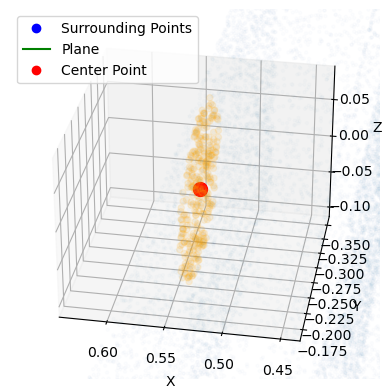

In [9]:
utils.visualize_plane(point0, neighbours0,point_cloud, radius,True)